In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import numpy as np
import torch

import matplotlib.pyplot as plt

from pathlib import Path

from tokeye.models.big_tf_unet.model_big_tf_unet import BigTFUNetModel
from tokeye.models.big_tf_unet.config_big_tf_unet import BigTFUNetConfig

In [29]:
ROOT_PATH = '/scratch/gpfs/nc1514/tokeye'
MODEL_FILE = 'big_tf_unet_251115.pt'
DATA_FILE = 'eval/D3D2025/170008/spec/co2_density_r0.npy'

root_path = Path(ROOT_PATH)
model_path = root_path / 'model' / MODEL_FILE
data_path = root_path / 'data' / DATA_FILE

In [71]:
config = BigTFUNetConfig()
state_dict = torch.load(model_path, weights_only=True)
model = BigTFUNetModel(config)
model.load_state_dict(state_dict)
model.eval()

print("Model loaded")

Model loaded


In [72]:
spectrogram = np.load(data_path)
print(f'Shape: {spectrogram.shape}')
print(f'Datatype: {spectrogram.dtype}')
print(f'Mean: {spectrogram.mean()}, Std: {spectrogram.std()}')

Shape: (512, 8397)
Datatype: float64
Mean: 55.2126320915381, Std: 2.0332788051617863


In [73]:
model_input = spectrogram
model_input = torch.from_numpy(model_input)
model_input = model_input.unsqueeze(0).unsqueeze(0).float()

vmin, vmax = torch.quantile(model_input, 0.01), torch.quantile(model_input, 0.99)
model_input = torch.clamp(model_input, vmin, vmax)
model_input = (model_input - model_input.mean()) / model_input.std()

print(f'Shape: {model_input.shape}')
print(f'Datatype: {model_input.dtype}')
print(f'Mean: {model_input.mean()}, Std: {model_input.std()}')

Shape: torch.Size([1, 1, 512, 8397])
Datatype: torch.float32
Mean: 6.832564736214408e-07, Std: 1.0


In [74]:
with torch.no_grad():
    model_output = model(model_input)[0]
    model_output = torch.sigmoid(model_output)

model_output = model_output.squeeze(0).cpu().numpy()
print(f'Shape: {model_output.shape}')
print(f'Datatype: {model_output.dtype}')
print(f'Mean: {model_output.mean()}, Std: {model_output.std()}')

Shape: (2, 512, 8397)
Datatype: float32
Mean: 0.5178542137145996, Std: 0.002732855034992099


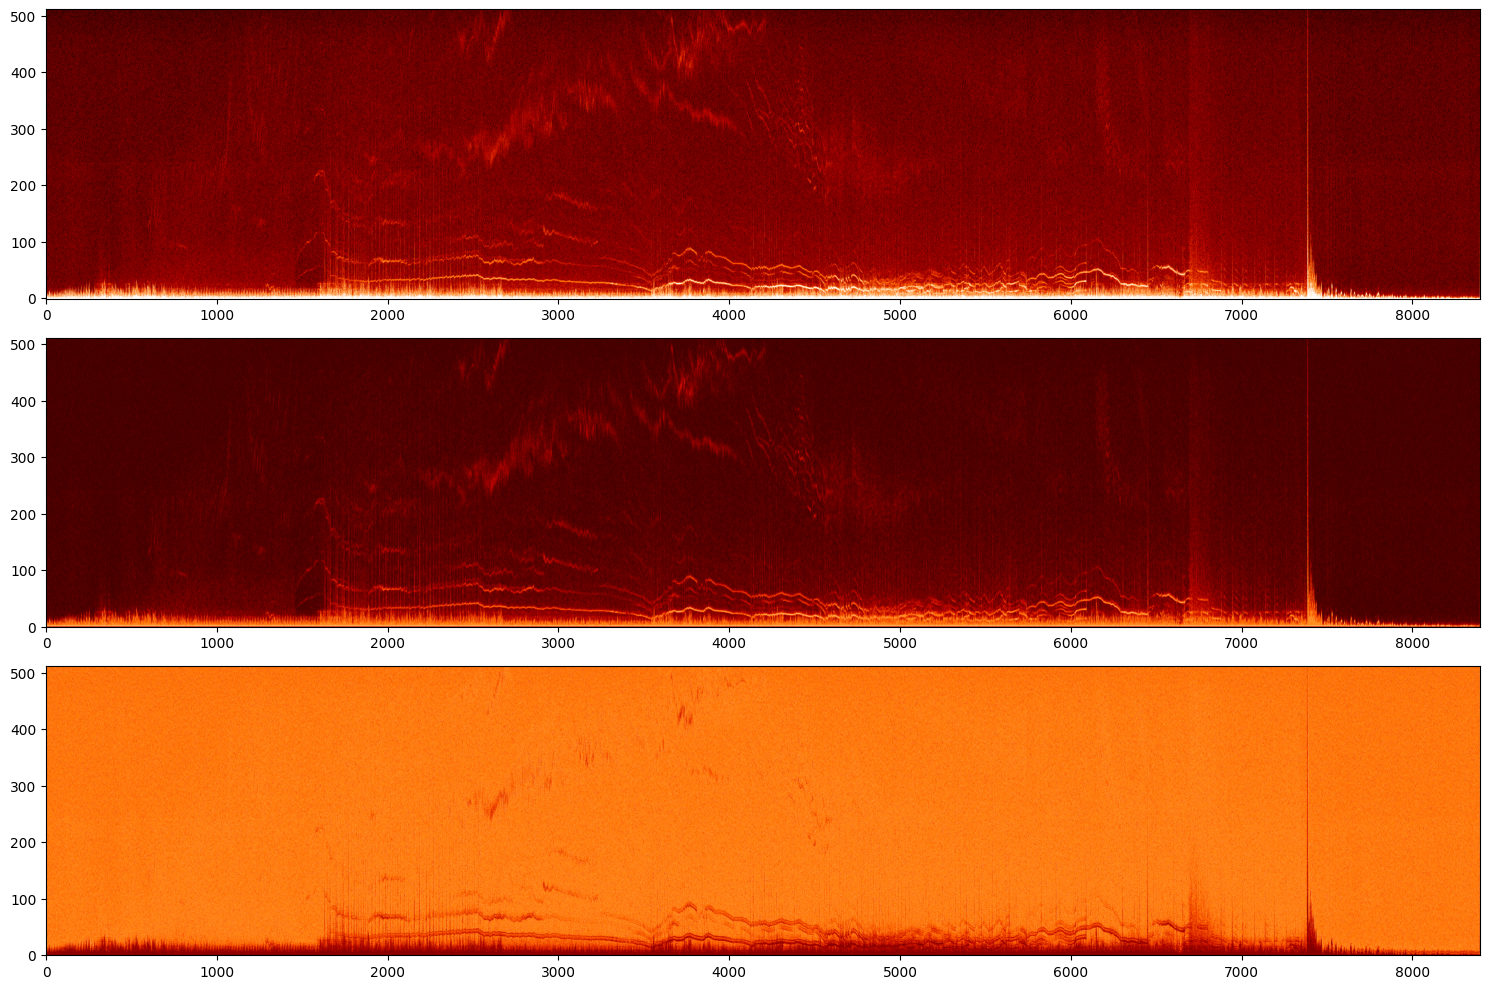

In [76]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Vertical spectrogram (transpose to make frequency vertical)
im0 = axes[0].imshow(
    spectrogram, 
    aspect='auto', 
    origin='lower', 
    cmap='gist_heat',
)

# First layer of model_output
im1 = axes[1].imshow(
    model_output[0], 
    aspect='auto', 
    origin='lower', 
    cmap='gist_heat',
    # vmin=0, vmax=1,
)

# Second layer of model_output
im2 = axes[2].imshow(
    model_output[1], 
    aspect='auto', 
    origin='lower', 
    cmap='gist_heat',
    # vmin=0, vmax=1,
)

plt.tight_layout()
plt.show()